# Predicting House Prices

The challenge is to predict house prices in Ames,Iowa. 
The dataset has been taken from Kaggle

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


plt.style.use(style='ggplot')
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(suppress=True)

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


In [2]:
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

train_df_copy = train_df.copy()
test_df_copy = test_df.copy()

In [3]:
print('Training set size:', train_df.shape)
print('Test set size:', test_df.shape)

Training set size: (1460, 81)
Test set size: (1459, 80)


In [4]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Exploring and cleaning variables

There are around 80 features, one target variable - Sale Price.
Lets understand each of these and check if they are actually useful for our problem.

Data Dictionary file can be found [here](https://storage.googleapis.com/kaggle-competitions-data/kaggle/5407/205873/data_description.txt?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1543902317&Signature=gn%2BX4%2B6Tml56r0dKye%2FTpJN%2Fg6M5OMk24vIGxrci0UsFm%2FJxuUm59HmpyjDJ5HF5uRrvJ0hJp2K6%2FDDty5SOlnvNsyQK7Z111guA5HElIHJ0x4zvNy95c1OyDbdxcXXN8Bqr2DzAZqCcE%2B0fWPT%2BwRWPKS1gDgnv%2BurdDlF%2FBIcJHeHFyFupu8Cu3s9PR7%2FgqkE7L%2B7uIXZ9%2F10%2FM34r%2Fkn6zo1HK95T7h1CjjGzGYAsId94Rb36MB8j5nqvAP9hpLyhThaRz5ZK9gUnHXdgR4Ei01kOt3H%2BL%2FE8LoWNJuX5%2Fs74%2FeAQ4nmwzL9jrf4vzc1pd8e%2BaEINCHXo%2BFX3aw%3D%3D)
Not all features influences the target variable(sale price).

Features that I would look for while buying a house would be:
* Location
* Size of house
* Facilities - like club house, swimming pool in society , etc
* Accessebility - like parks,schools in vicinity

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

Above is a quick info about dataset.
We can remove features :
* which you think will not influence the target variable(irrelevant features)
* that leaks information from the future (this will lead to overfit of the data)

After examining each of the features,I came up with below list.
Also many of the features are correlated to each other(multicollinearity) and so can be ignored.
Features that may affect the price of house according to me are:
* Utilities - Type of utilities available
* OverallQual or OverallCond - we can pick any one
* YearBuilt
* TotalBsmtSF - Total basement area in square feet
* GrLivArea   - Above ground living area in square feet
* TotRmsAbvGrd - Total rooms above grade
* GarageCars or GarageArea - we can pick any one
* GarageQual or GarageCond - GarageArea/GarageCars feature is enough to decide on which house to buy. So we can ignore GarageQUal and GarageCond

As you can see,just examining the each of the feature and thinking on it as per the problem context reduced the feature count.

Considering only these features. 
Lets see descriptive statistics of each of them

In [6]:
features = ['Utilities','OverallQual','YearBuilt','TotalBsmtSF','GrLivArea','TotRmsAbvGrd','GarageArea','SalePrice']
train_df[features].describe(include='all').transpose()


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Utilities,1460,2,AllPub,1459,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OverallQual,1460,NaN,NaN,NaN,6.09932,1.383,1,5,6,7,10
YearBuilt,1460,NaN,NaN,NaN,1971.27,30.2029,1872,1954,1973,2000,2010
TotalBsmtSF,1460,NaN,NaN,NaN,1057.43,438.705,0,795.75,991.5,1298.25,6110
GrLivArea,1460,NaN,NaN,NaN,1515.46,525.48,334,1129.5,1464,1776.75,5642
TotRmsAbvGrd,1460,NaN,NaN,NaN,6.51781,1.62539,2,5,6,7,14
GarageArea,1460,NaN,NaN,NaN,472.98,213.805,0,334.5,480,576,1418
SalePrice,1460,NaN,NaN,NaN,180921,79442.5,34900,129975,163000,214000,755000


* Utilities - categorical variable with only 2 unique values -with 'AllPub' value being most common ,we can remove this     variable, as my model wont learn anything from it
* OverallQual - Its like rating varible so should be categorical,but stored in dataframe as integer.
* YearBuilt - Again should be categorical variable,we should check how it affects Sale Price of the house
* TotalBsmtSF - minimum value 0 - how can this happen ?may be for houses with no basement
* GrLivArea - standard deviation is high, seems huge variation in living areas in different houses
* GarageArea - again 0 minimum value - may be houses with no garage.
* TotalRmsAbvGround - So any house would have minimum 2 rooms & at most 14 rooms
* Sale Price - Average house price in this dataset is around 180k dollars,with 50% of houses having selling price of 163k dollars


In [7]:
#lets drop other features which does not look important w.r.t. target variable
train_df = train_df[features] #this removes remaining variables

test_df = test_df[['Utilities','OverallQual','YearBuilt','TotalBsmtSF','GrLivArea','TotRmsAbvGrd','GarageArea']]

#other changes
train_df.drop('Utilities',inplace=True,axis = 1)
features.remove('Utilities')
train_df[['OverallQual','YearBuilt']] = train_df[['OverallQual','YearBuilt']].astype(object)
train_df[['TotalBsmtSF','GarageArea','GrLivArea','SalePrice']] = train_df[['TotalBsmtSF','GarageArea','GrLivArea','SalePrice']].astype(float)

test_df.drop('Utilities',inplace=True,axis = 1)
test_df[['OverallQual','YearBuilt']] = test_df[['OverallQual','YearBuilt']].astype(object)
test_df[['TotalBsmtSF','GarageArea','GrLivArea',]] = test_df[['TotalBsmtSF','GarageArea','GrLivArea']].astype(float)
print()

In [8]:
train_df.dtypes

OverallQual      object
YearBuilt        object
TotalBsmtSF     float64
GrLivArea       float64
TotRmsAbvGrd      int64
GarageArea      float64
SalePrice       float64
dtype: object

Now the datatypes of variables looks fine.

The challenge is to predict the final sale price of homes.This is stored in Sale Price column

## Exploratory data analysis

### Univariate Analysis

Lets start with target variable - Sale Price of house

In [9]:
# summary statistic of Sale price variable
train_df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

The average selling price of house in our dataset is around 180,000 dollars, <br> with most of values falling between dollar 130,000 & $214,000.<br>
The standard deviation is 79442 - i.e values are very much variable.
Lets plot it and see.

((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([  34900.,   35311.,   37900., ...,  625000.,  745000.,  755000.])),
 (74160.164745194154, 180921.19589041095, 0.93196656415129864))

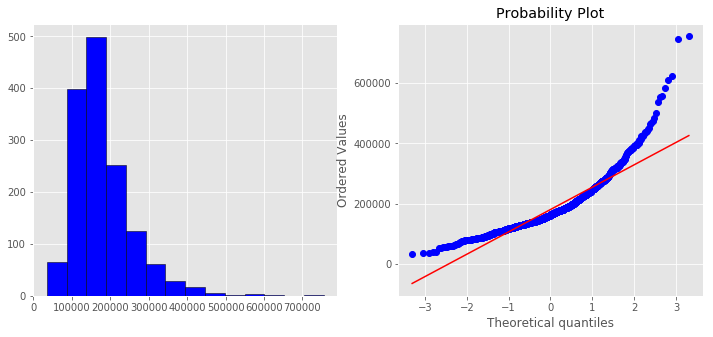

In [10]:
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.hist(train_df['SalePrice'] , color='blue', edgecolor='black', bins = 14)
stats.probplot(train_df['SalePrice'], plot=ax2)

Distribution is strongly right skewed.<br>
Machine learning models works well with normal data.<br>
To transform this to normal distribution, lets take log of Sale Price.<br>
Also, the probability plot shows that this data is not normally distributed.

((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([ 10.46024211,  10.47194981,  10.54270639, ...,  13.34550693,
          13.5211395 ,  13.53447303])),
 (0.39826223081618878, 12.024050901109383, 0.99537614756366133))

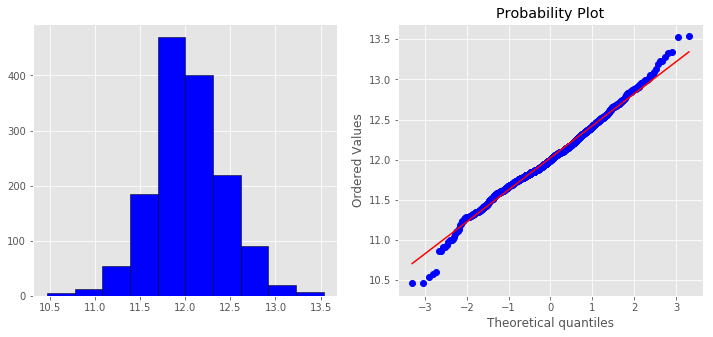

In [11]:
train_df['SalePrice'] = np.log(train_df['SalePrice'])

fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.hist(train_df['SalePrice'], edgecolor='black', color='blue')
stats.probplot(train_df['SalePrice'], plot=ax2)

Lets now consider other features.

In [12]:
train_df.columns

Index(['OverallQual', 'YearBuilt', 'TotalBsmtSF', 'GrLivArea', 'TotRmsAbvGrd',
       'GarageArea', 'SalePrice'],
      dtype='object')

Text(0,0.5,'Count')

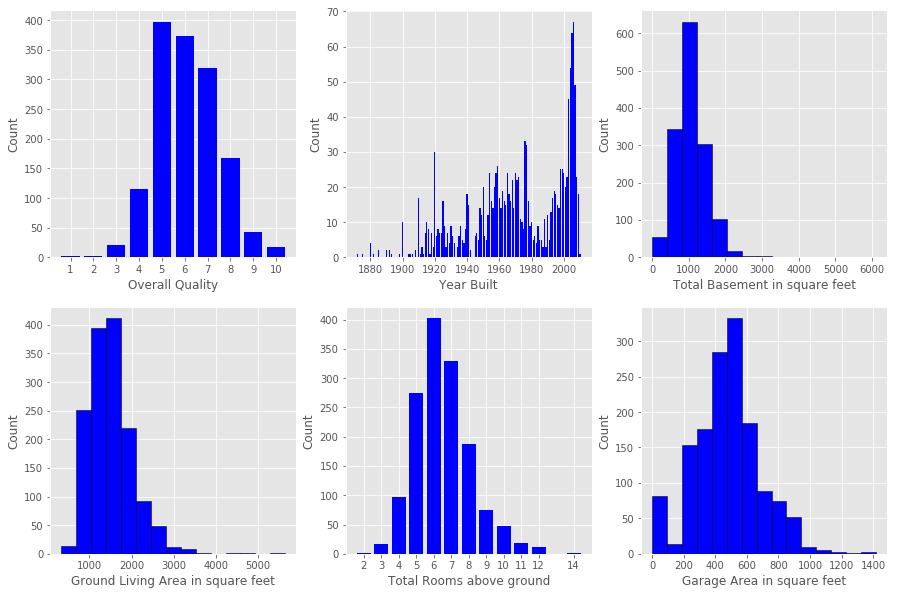

In [13]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
#ax3 = fig.add_subplot(333)
#ax4 = fig.add_subplot(334)
ax5 = fig.add_subplot(233)
ax6 = fig.add_subplot(234)
ax7 = fig.add_subplot(235)
ax8 = fig.add_subplot(236)

overall_qual = train_df['OverallQual'].value_counts()
#overall_cond = train_df['OverallCond'].value_counts()
year_built = train_df['YearBuilt'].value_counts()
#bsmnt_qual = train_df['BsmtQual'].value_counts()
total_rooms = train_df['TotRmsAbvGrd'].value_counts()

ax1.bar(overall_qual.index, overall_qual.values, color='blue')
ax1.set_xlabel('Overall Quality')
ax1.set_ylabel('Count')
ax1.set_xticks(overall_qual.index)

#ax2.bar(overall_cond.index, overall_cond.values, color='blue')
#ax2.set_xlabel('Overall Condition')
#ax2.set_ylabel('Count')
#ax2.set_xticks(overall_cond.index)

ax2.bar(year_built.index, year_built.values, color='blue')
ax2.set_xlabel('Year Built')
ax2.set_ylabel('Count')

#ax4.bar(bsmnt_qual.index, bsmnt_qual.values, color='blue')
#ax4.set_xlabel('Basement Quality')
#ax4.set_ylabel('Count')

ax5.hist(train_df['TotalBsmtSF'], edgecolor='black', bins = 15, color='blue')
ax5.set_xlabel('Total Basement in square feet')
ax5.set_ylabel('Count')

ax6.hist(train_df['GrLivArea'], edgecolor='black', bins = 15, color='blue')
ax6.set_xlabel('Ground Living Area in square feet')
ax6.set_ylabel('Count')

ax7.bar(total_rooms.index, total_rooms.values, color='blue')
ax7.set_xlabel('Total Rooms above ground')
ax7.set_xticks(total_rooms.index)
ax7.set_ylabel('Count')

ax8.hist(train_df['GarageArea'], edgecolor='black', bins = 15, color='blue')
ax8.set_xlabel('Garage Area in square feet')
ax8.set_ylabel('Count')


Following conclusions can be made:
* Overall Quality:
   * 1- being Very Poor , 10 - being Very Excellent
   * Most of the houses have overall quality rating 5,6 or 7 i.e Average or Good.
   * I can merge the sparse classes 1,2,3,4 & 5,6,7 & 8,9,10 - into respective single classes

* Year Built - Most of the houses in the dataset are built recently,around year 2000 and above
* Total Rooms above ground - Usually houses have 5 to 8 no. of rooms
* Total basement area & Ground living area - right skewed - need to convert it into normal distribution
* Garage Area - Some houses have no garage,while most have 400 to 600 square feet area. 

In [14]:
def encode(x):
    if (x==1) or(x == 2) or (x==3) or (x==4): return 1
    elif (x == 5) or (x==6) or (x==7): return 2
    elif (x == 8) or (x==9) or (x==10): return 3
    

In [15]:
#merge sparse classes into one & too many classes into one
train_df['OverallQual'] = train_df['OverallQual'].apply(encode)
test_df['OverallQual']  = test_df['OverallQual'].apply(encode)


#log transform features
train_df['TotalBsmtSF'] = np.log(train_df['TotalBsmtSF'] + 1) #to avoid division by zero
train_df['GrLivArea'] = np.log(train_df['GrLivArea'])

test_df['TotalBsmtSF'] = np.log(test_df['TotalBsmtSF'] + 1) #to avoid division by zero
test_df['GrLivArea'] = np.log(test_df['GrLivArea'])

### Multivariate Analysis

In [16]:
#relationship between features
#goal is to examine relationships between target and features

corr = train_df.corr()

print(corr['SalePrice'].sort_values(ascending=False)[:10]) #top 10 positive relationship
print()
#print(corr['SalePrice'].sort_values(ascending=False)[-10:]) #lowest 10 negative relationship

SalePrice       1.000000
GrLivArea       0.730255
OverallQual     0.695498
GarageArea      0.650888
TotRmsAbvGrd    0.534422
TotalBsmtSF     0.372838
Name: SalePrice, dtype: float64



Also lets visualize the relation between features and target variable.<br>
Strong correlation value between variables doesnt actually mean that they are linearly related,<br> they may also be quadritically related.<br>
To verify this we can visualize the relation

Text(0.5,1,'Sale Price increases as quality of house increases')

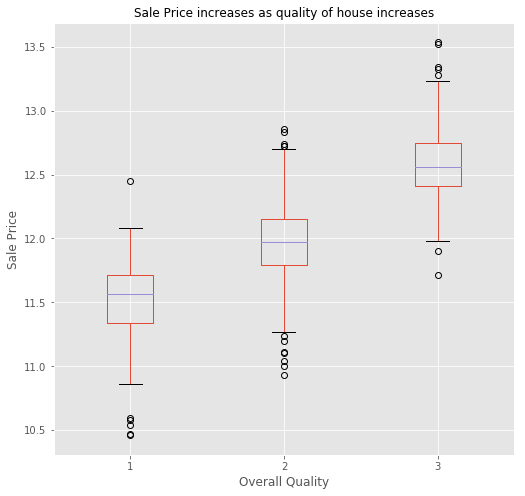

In [17]:
fig, ax = plt.subplots(figsize=(8,8))
train_df.boxplot(column='SalePrice', by='OverallQual', ax=ax)
plt.suptitle("")
plt.ylabel('Sale Price')
plt.xlabel('Overall Quality')
plt.title('Sale Price increases as quality of house increases', fontsize=12)

Next,lets visualize relationship between GrLivArea(Ground Living Area) and Sale Price

Text(0.5,1,'Sale Price increases with increase in ground area')

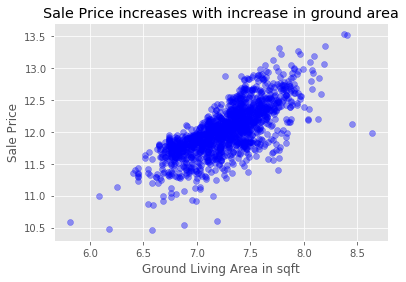

In [18]:
plt.scatter(x=train_df['GrLivArea'], y=train_df['SalePrice'], alpha=0.4, color='blue')
plt.ylabel('Sale Price')
plt.xlabel('Ground Living Area in sqft')
plt.title('Sale Price increases with increase in ground area')

Immediately,we can see that increase in living area increases Sale price.<br>
Lets do same for GarageArea.


Text(0.5,1,'Sale Price increases with increase in garage area')

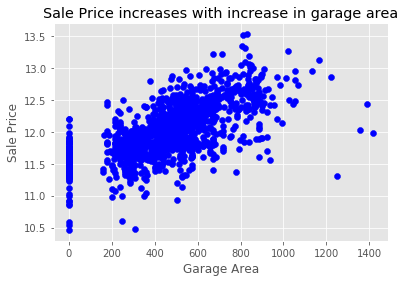

In [19]:
plt.scatter(x=train_df['GarageArea'], y=train_df['SalePrice'],color='blue')
plt.ylabel('Sale Price')
plt.xlabel('Garage Area')
plt.title('Sale Price increases with increase in garage area')

Here also we can see linear relationship.<br>
There are many houses with 0 garage area - means that they have no garage area.<br>
There seems some outliers beyond 1200sqft garage area.<br>
Lets remove them

In [20]:
train_df = train_df[train_df['GarageArea'] < 1200]
test_df = test_df[test_df['GarageArea'] < 1200]

Lets check again

Text(0.5,0,'Garage Area')

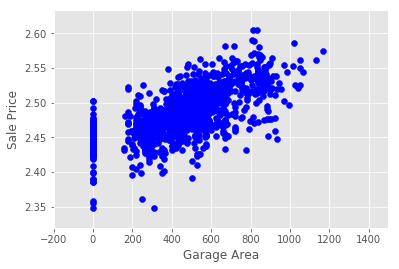

In [21]:
plt.scatter(x=train_df['GarageArea'], y=np.log(train_df['SalePrice']),color='blue')
plt.xlim(-200,1500) #this forces same scale as before
plt.ylabel('Sale Price')
plt.xlabel('Garage Area')

Text(0.5,0,'Total BAsement area')

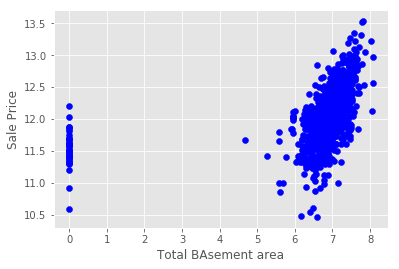

In [22]:
plt.scatter(x=train_df['TotalBsmtSF'], y=train_df['SalePrice'],color='blue')
plt.ylabel('Sale Price')
plt.xlabel('Total BAsement area')

Again, Total Basement Area has linear relationship with Sale Price

Now with 'Year Built' variable,lets create another variable 'yrs_old' which tells how old is the house.<br>
This new feature will be more helpful as it will have direct relationship with target variable


In [23]:
train_df['yrs_old'] = 2018 - train_df['YearBuilt']
test_df['yrs_old'] = 2018 - test_df['YearBuilt']

train_df.drop('YearBuilt',axis=1, inplace=True)
test_df.drop('YearBuilt', axis=1, inplace=True)

In [24]:
#binning yrs_old fetaure
    
#bin_ranges = [0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150]
#bin_names = np.arange(1,16)
#train_df['label'] = pd.cut(np.array(train_df['yrs_old']), bins=bin_ranges, labels=bin_names)
#train_df.drop('label',axis=1,inplace=True)

In [25]:
train_df.head()

,OverallQual,TotalBsmtSF,GrLivArea,TotRmsAbvGrd,GarageArea,SalePrice,yrs_old
0,2,6.753438,7.444249,8,548.0,12.247694,15
1,2,7.141245,7.140453,6,460.0,12.109011,42
2,2,6.825460,7.487734,6,608.0,12.317167,17
3,2,6.629363,7.448334,7,642.0,11.849398,103
4,3,7.044033,7.695303,9,836.0,12.429216,18


In [26]:
#create new feature - total house area
#rename column names of df
#standardize garage area feature

In [27]:
test_df.head()

,OverallQual,TotalBsmtSF,GrLivArea,TotRmsAbvGrd,GarageArea,yrs_old
0,2,6.783325,6.797940,5,730.0,57
1,2,7.192934,7.192182,6,312.0,60
2,2,6.834109,7.395722,6,482.0,21
3,2,6.831954,7.380256,7,470.0,20
4,3,7.155396,7.154615,5,506.0,26


Lets check missing values


In [28]:
train_df.isnull().sum()

OverallQual     0
TotalBsmtSF     0
GrLivArea       0
TotRmsAbvGrd    0
GarageArea      0
SalePrice       0
yrs_old         0
dtype: int64

As there are no missing values,we can proceed with Modelling phase

## Modelling

In [29]:
from sklearn.model_selection import learning_curve,train_test_split, RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


In [30]:
X = train_df.drop('SalePrice', axis=1)
y = train_df['SalePrice']

In [32]:
X_train, X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#now keep X_test & y_test aside totally


In [52]:
model = LinearRegression()
model.fit(X_train, y_train)
ytrain_predictions = model.predict(X_train)
training_error = mean_squared_error(y_train,ytrain_predictions)

ytest_predictions = model.predict(X_test)
test_error = mean_squared_error(y_test, ytest_predictions)

print('Training error', training_error)

print('Test error', test_error)
print('Co-efficients', model.coef_)

Training error 0.0296784684032
Test error 0.0309755026817
Co-efficients [ 0.18451453  0.03885292  0.61179829 -0.01556694  0.00033928 -0.00331362]


There seems not much difference between training error & test error, this means that our model generalizes well to unseen data
<br>
These co-efficients are weightage to each feature used

In [54]:
X_train.columns

Index(['OverallQual', 'TotalBsmtSF', 'GrLivArea', 'TotRmsAbvGrd', 'GarageArea',
       'yrs_old'],
      dtype='object')

Lets view this relationship graphically with scatter plot

Text(0.5,1,'Linear Regression Model')

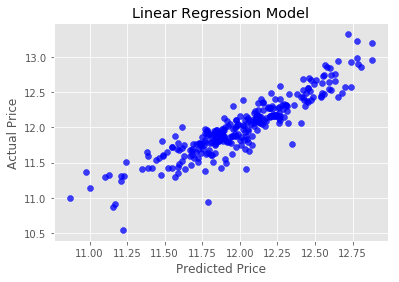

In [40]:
plt.scatter(ytest_predictions, y_test, alpha=0.75, color='b')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Linear Regression Model')

If our predicted values were identical to actual values,this graph would have been the straight line y=x, <br>
because each predicted value x would be equal to each actua value y

<br>
Lets now predict house prices of test set provided to us

Test set contains one missing value for Total BAsement area column, we can discard  this row

In [62]:
test_df.dropna(axis=0,inplace=True)


In [67]:
test_predictions = model.predict(test_df)

In [74]:
test_df['SalePrice'] = test_predictions

In [129]:
test_df['SalePrice'] = np.round(np.exp(test_df['SalePrice']))

In [133]:
submit = pd.concat([test_df['SalePrice'], test_df_copy] , axis=1)
submit = submit[['Id', 'SalePrice']]

In [134]:
submit.to_csv('Submission.csv',index=False)